# *Notebook pour l'analyse et la manipulation des données*

# **Construisez un modèle de scoring**



![logo.JPG](data/img/logo.JPG)

La société financière **"Prêt à dépenser"** propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Le but est donc de développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

---

## Sommaire

<ol>
    <li><a href="#">Environnement de développement</a></li>
        <ol>
            <li><a href="#installation">Installation de l'environnement</a></li>
            <li><a href="#librairies">Import des librairies</a></li>
        </ol>
    <li><a href="#">Chargement des données</a></li>
    <li><a href="#">Analyse exploratoire</a></li>
        <ol>
            <li><a href="#">Colonne TARGET</a></li>
            <li><a href="#">Valeurs manquantes</a></li>
            <li><a href="#">Types des colonnes</a></li>
            <li><a href="#">Analyse des variables</a></li>  
        </ol>
    <li><a href="#">Merge des fichiers, nettoyage et création de nouvelles variables</a></li>
        <ol>
            <li><a href="#">Nettoyage</a></li>
            <li><a href="#">Encodage des variables catégorielles</a></li>
            <li><a href="#">Création de nouvelles features</a></li>
        </ol>
    <li><a href="#">Fusion des autres fichiers, encodage et créations d'autres variables</a></li>
</ol>



<a id="environnement"></a>
# Environnement de développement

<a id="installation"></a>
### Installation de l'environnement

Un environnement virtuel a été créé pour assurer l’isolement du projet et la gestion des dépendances.
Les informations de cet environnement (son nom et ses dépendances) sont précisées dans le fichier **environment.yml**

L'installation de l'environnement virtuel est possible à partir de ce fichier, dans un invite de commande lancer la commande :

<code>conda env create -f environment.yml</code>

<a id="librairies"></a>
### Import des librairies

In [58]:
%reload_ext autoreload
%autoreload 2

import gc

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

# sklearn preprocessing pour traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt
import seaborn as sns

#autres librairies
import missingno as msno

# Import des modules contenant les fonctions utilitaires
import src.my_module.data_helpers as dth

In [59]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

# Chargement des données

In [60]:
#Affichage de la liste des différents fichiers
print("Liste des fichiers :")
for file in os.listdir("data/"):
    if file.endswith(".csv"):
        print("- " + file)

Liste des fichiers :
- application_test.csv
- application_train.csv
- bureau.csv
- bureau_balance.csv
- credit_card_balance.csv
- HomeCredit_columns_description.csv
- installments_payments.csv
- POS_CASH_balance.csv
- previous_application.csv
- sample_submission.csv


Ces fichiers sont fournis par <a href="https://www.homecredit.net//">Home Credits</a>, un service dédié à l'octroi de crédits à ceux qui n'ont pas d'historique de crédit.

Le diagramme suivant montre comment toutes les données de ces fichiers sont liées entre elles:

![home_credit.png](data/img/home_credit.png)

Pour plus de précision, on retrouve la définition de chaque colonne dans le fichier **HomeCredit_columns_description.csv**

On va charger dans un premier temps les données des fichiers **application_train.csv** et **application_test.csv**, que l'on va fusionner pour ensuite effectuer un nettoyage et créer de nouvelles features. On séparera par la suite le dataset correctement pour l'entraînement de nos différents modèles, car :

- Le fichier **application_train.csv** contient la colonne TARGET, qui est la valeur que l'on essaye de prédire, alors que le fichier **application_test.csv** quand à lui ne contient pas cette colonne TARGET.

In [61]:
# Jeu d'entraînement
data = pd.read_csv('data/application_train.csv')
dth.displayDataShape("Le jeu d'entraînement contient", data)

Le jeu d'entraînement contient : 307511 lignes et 122 colonnes



In [62]:
data.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   
8               Y             0          112500.0   1019610.0      33826.5   
9               Y             0          135000.0    405000.0      20250.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   
5  ...                 0                0                0                0   
6  ...                 0                0                0                0   
7  ...                 0                0                0                0   
8  ...                 0                0                0                0   
9  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   
5                        0.0                       0.0   
6                        0.0                       0.0   
7                        0.0                       0.0   
8                        0.0                       0.0   
9                        NaN                       NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   
5                         0.0                        0.0   
6                         0.0                        1.0   
7                         0.0                        0.0   
8                         0.0                        0.0   
9                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0         

In [63]:
# Jeu de test
test_data = pd.read_csv('data/application_test.csv')
dth.displayDataShape("Le jeu de test contient", test_data)

Le jeu de test contient : 48744 lignes et 121 colonnes



In [64]:
test_data.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

Le jeu de test est plus petit et ne contient pas la variable TARGET

# Analyse exploratoire
Avant de fusionner les 2 fichiers (train et test) pour effectuer différents traitements, nous analyserons les différentes variables du jeu de données d'entraînement.

### La colonne TARGET
La variable **TARGET** est celle que notre modèle doit prédire

- TARGET=1 correspond à un prêt non remboursé
- TARGET=0 correspond à un prêt remboursé

In [65]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Nous avons affaire ici à un problème de classification binaire, avec un **jeu d'entraînement déséquilibré**.
Il y a beaucoup plus de prêts remboursés que de prêts non remboursés. (**92% de prêts remboursés**)

Avant d'entraîner un modèle supervisé, il faudra rééquilibrer le jeu de données afin d'obtenir un nombre identique de classes pour la TARGET.

### Valeurs manquantes
On va maintenant examiner le nombre de valeurs manquantes pour chaque colonne

In [66]:
print("Affichage du nombre de valeurs manquantes en % pour chaque colonne")
dth.displayNanPercent(data)

Affichage du nombre de valeurs manquantes en % pour chaque colonne
Le jeu de données contient 122 colonnes.
67 colonnes ont des valeurs manquantes.


Valeurs manquantes  % de valeurs manquantes
COMMONAREA_MEDI                       214865                     69.9
COMMONAREA_AVG                        214865                     69.9
COMMONAREA_MODE                       214865                     69.9
NONLIVINGAPARTMENTS_MEDI              213514                     69.4
NONLIVINGAPARTMENTS_MODE              213514                     69.4
...                                      ...                      ...
EXT_SOURCE_2                             660                      0.2
AMT_GOODS_PRICE                          278                      0.1
AMT_ANNUITY                               12                      0.0
CNT_FAM_MEMBERS                            2                      0.0
DAYS_LAST_PHONE_CHANGE                     1                      0.0

[67 rows x 2 columns]

Affichage graphique du remplissage des colonnes


<AxesSubplot:>

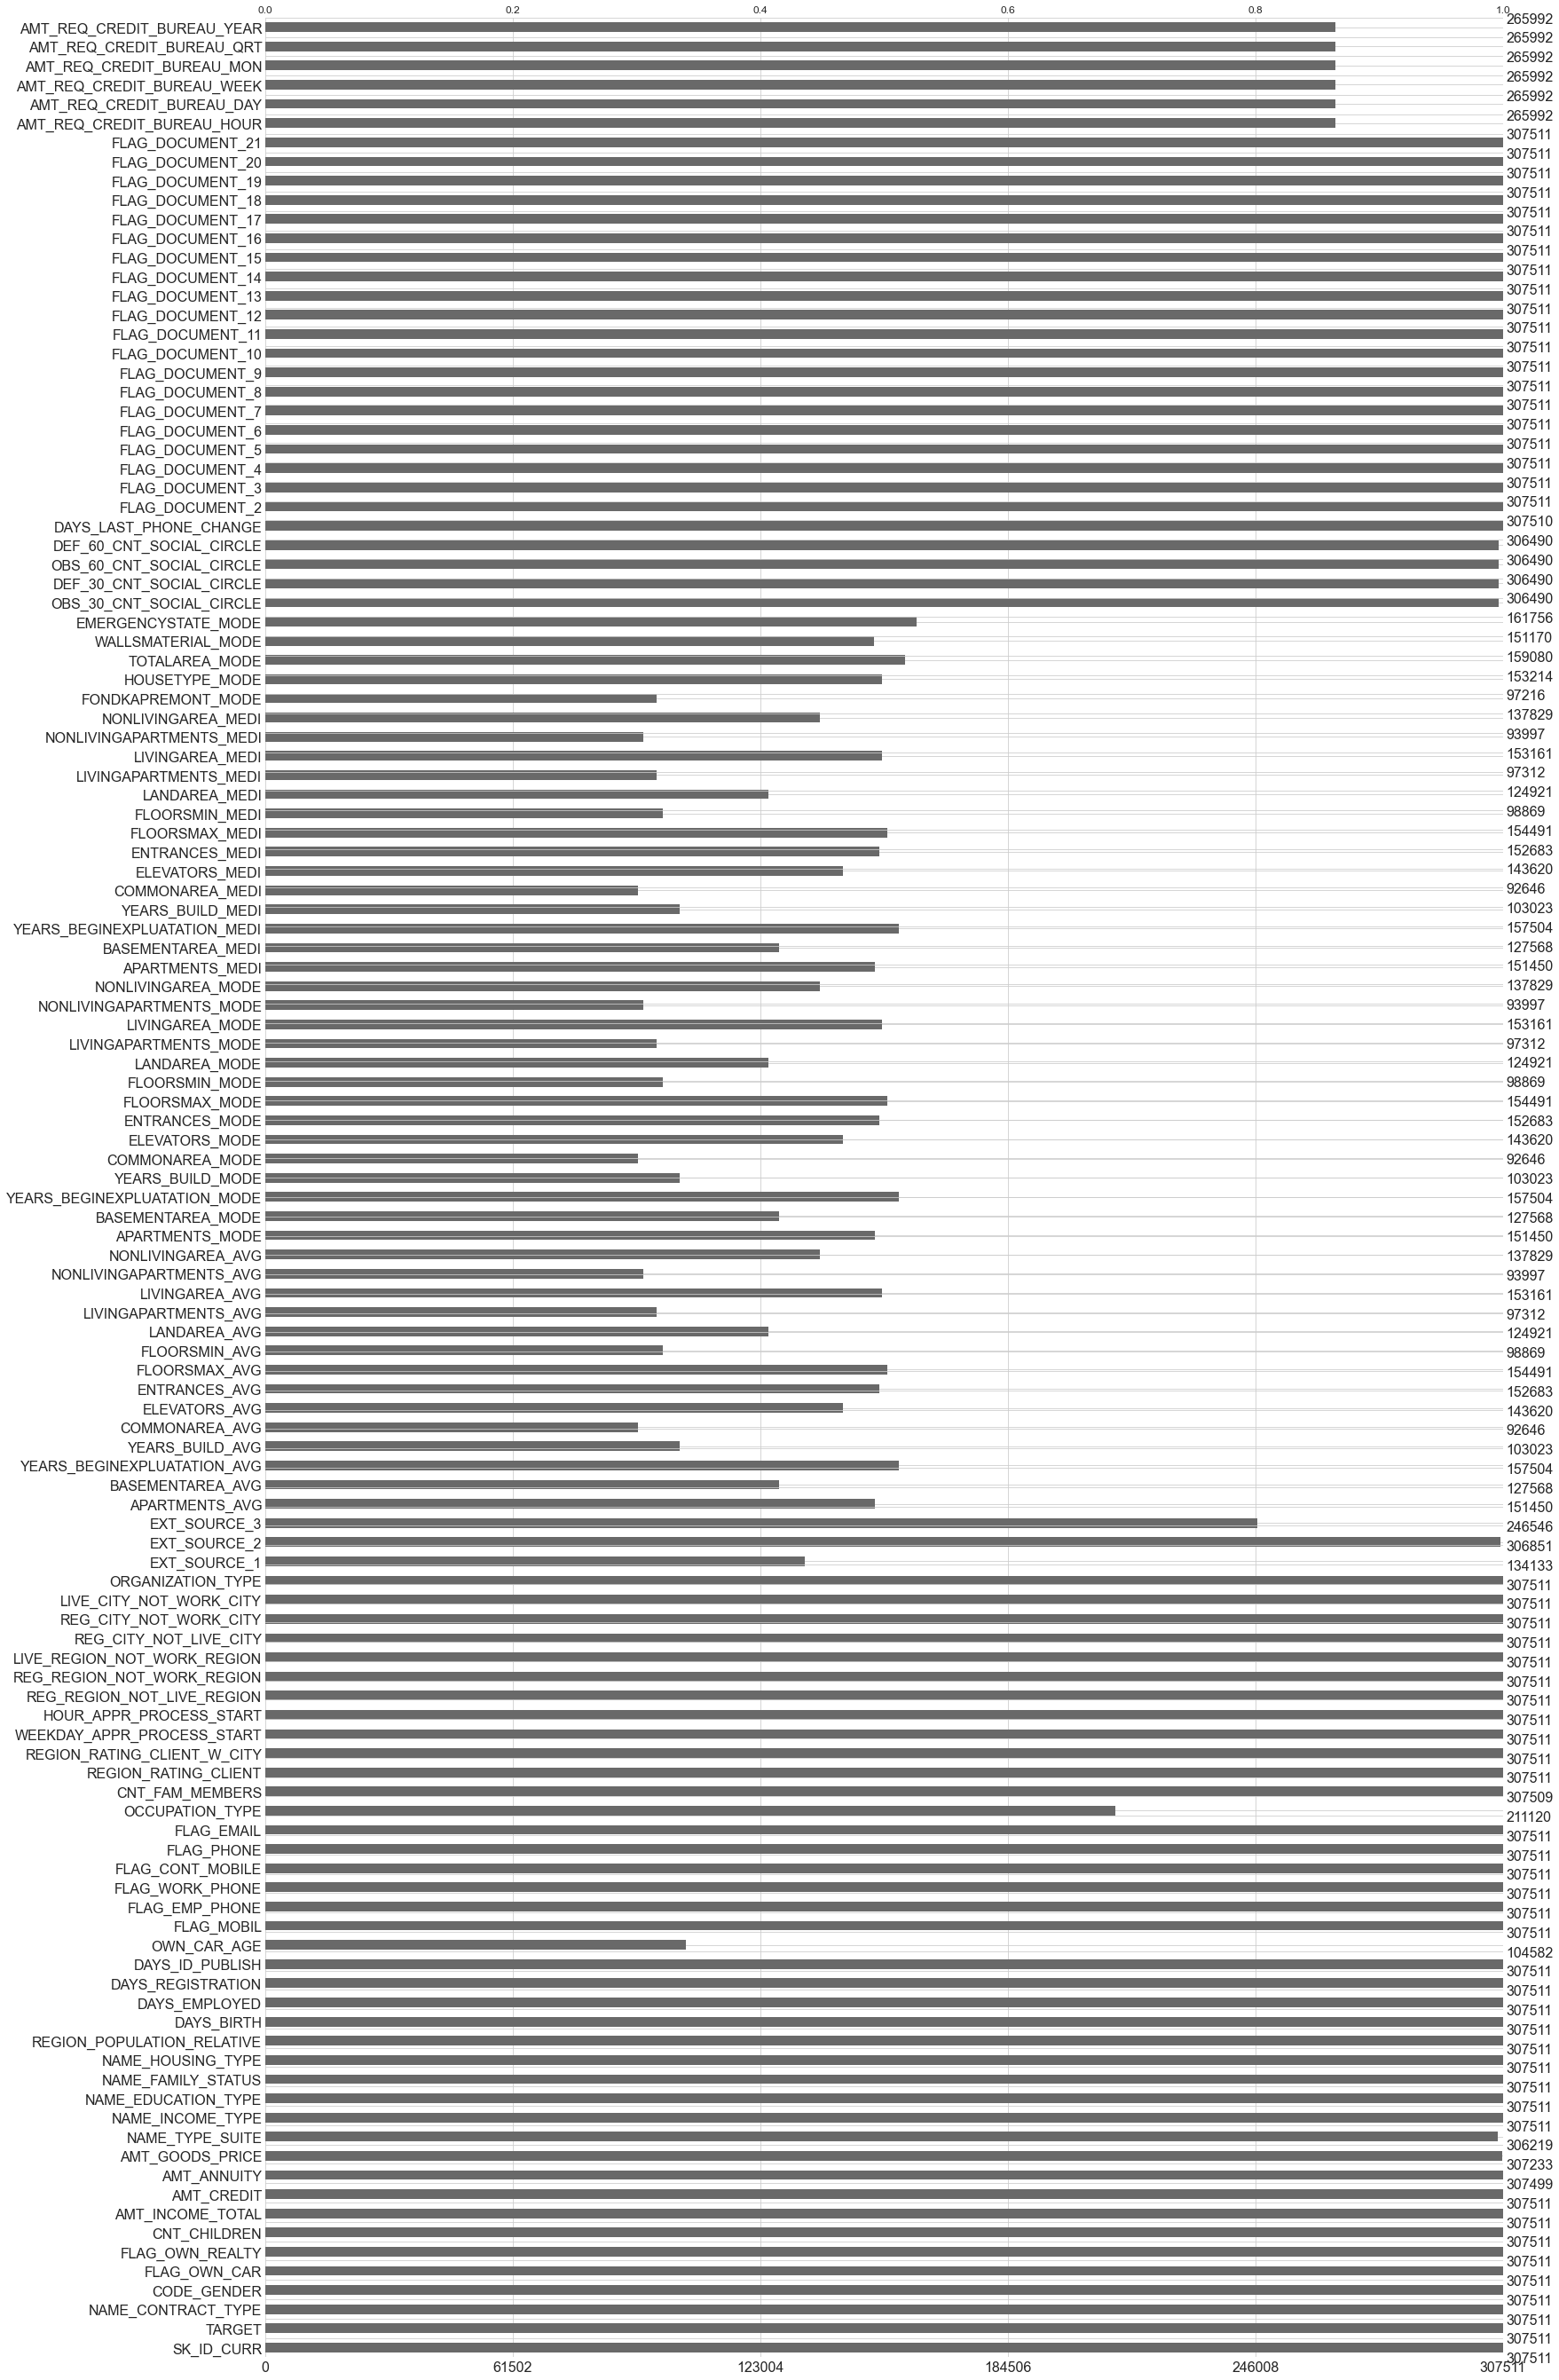

In [67]:
print("Affichage graphique du remplissage des colonnes")
msno.bar(data)

La plupart des colonnes sont bien remplies, et les moins remplies ont au moins 30% de valeurs non nulles, on va donc garder toutes les colonnes pour le moment.

Cela ne devrait pas poser de problème pour la suite de cette partie, mais il faudra quand même imputer ces valeurs manquantes avant d'entraîner nos modèles supervisés.

### Types des colonnes

On va regarder le type des colonnes et de quoi elles sont composées

In [68]:
data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Il y a 16 variables catégorielles, 41 variables sont des entiers, et 65 sont des nombres flottants

In [69]:
data_object_infos = data.select_dtypes("object").describe().T
data_object_infos["unique"] = data.select_dtypes("object").apply( pd.Series.unique, axis=0)
data_object_infos["nunique"] = data.select_dtypes("object").apply( pd.Series.nunique, axis=0)
data_object_infos

count  \
NAME_CONTRACT_TYPE          307511   
CODE_GENDER                 307511   
FLAG_OWN_CAR                307511   
FLAG_OWN_REALTY             307511   
NAME_TYPE_SUITE             306219   
NAME_INCOME_TYPE            307511   
NAME_EDUCATION_TYPE         307511   
NAME_FAMILY_STATUS          307511   
NAME_HOUSING_TYPE           307511   
OCCUPATION_TYPE             211120   
WEEKDAY_APPR_PROCESS_START  307511   
ORGANIZATION_TYPE           307511   
FONDKAPREMONT_MODE           97216   
HOUSETYPE_MODE              153214   
WALLSMATERIAL_MODE          151170   
EMERGENCYSTATE_MODE         161756   

                                                                       unique  \
NAME_CONTRACT_TYPE                              [Cash loans, Revolving loans]   
CODE_GENDER                                                       [M, F, XNA]   
FLAG_OWN_CAR                                                           [N, Y]   
FLAG_OWN_REALTY                                                        [Y, N]   
NAME_TYPE_SUITE             [Unaccompanied, Family, Spouse, partner, Child...   
NAME_INCOME_TYPE            [Working, State servant, Commercial associate,...   
NAME_EDUCATION_TYPE         [Secondary / secondary special, Higher educati...   
NAME_FAMILY_STATUS          [Single / not married, Married, Civil marriage...   
NAME_HOUSING_TYPE           [House / apartment, Rented apartment, With par...   
OCCUPATION_TYPE             [Laborers, Core staff, Accountants, Managers, ...   
WEEKDAY_APPR_PROCESS_START  [WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY...   
ORGANIZATION_TYPE           [Business Entity Type 3, School, Government, R...   
FONDKAPREMONT_MODE          [reg oper account, nan, org spec account, reg ...   
HOUSETYPE_MODE              [block of flats, nan, terraced house, specific...   
WALLSMATERIAL_MODE          [Stone, brick, Block, nan, Panel, Mixed, Woode...   
EMERGENCYSTATE_MODE                                            [No, nan, Yes]   

                                                      top    freq  nunique  
NAME_CONTRACT_TYPE                             Cash loans  278232        2  
CODE_GENDER                                             F  202448        3  
FLAG_OWN_CAR                                            N  202924        2  
FLAG_OWN_REALTY                                         Y  213312        2  
NAME_TYPE_SUITE                             Unaccompanied  248526        7  
NAME_INCOME_TYPE                                  Working  158774        8  
NAME_EDUCATION_TYPE         Secondary / secondary special  218391        5  
NAME_FAMILY_STATUS                                Married  196432        6  
NAME_HOUSING_TYPE                       House / apartment  272868        6  
OCCUPATION_TYPE                                  Laborers   55186       18  
WEEKDAY_APPR_PROCESS_START                        TUESDAY   53901        7  
ORGANIZATION_TYPE                  Business Entity Type 3   67992       58  
FONDKAPREMONT_MODE                       reg oper account   73830        4  
HOUSETYPE_MODE                             block of flats  150503        3  
WALLSMATERIAL_MODE                                  Panel   66040        7  
EMERGENCYSTATE_MODE                                    No  159428        2

In [70]:
data_int_infos = pd.DataFrame(data.select_dtypes("int64").apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
data_int_infos["valeur unique"] = data.select_dtypes("int64").apply(pd.Series.unique,axis=0)
data_int_infos.sort_values(by="Nombre de valeur unique")

Nombre de valeur unique  \
LIVE_CITY_NOT_WORK_CITY                            2   
FLAG_DOCUMENT_3                                    2   
FLAG_DOCUMENT_4                                    2   
FLAG_DOCUMENT_5                                    2   
FLAG_DOCUMENT_6                                    2   
FLAG_DOCUMENT_7                                    2   
FLAG_DOCUMENT_8                                    2   
FLAG_DOCUMENT_9                                    2   
FLAG_DOCUMENT_10                                   2   
FLAG_DOCUMENT_11                                   2   
FLAG_DOCUMENT_12                                   2   
FLAG_DOCUMENT_13                                   2   
FLAG_DOCUMENT_14                                   2   
FLAG_DOCUMENT_15                                   2   
FLAG_DOCUMENT_16                                   2   
FLAG_DOCUMENT_17                                   2   
FLAG_DOCUMENT_18                                   2   
FLAG_DOCUMENT_19                                   2   
FLAG_DOCUMENT_2                                    2   
FLAG_DOCUMENT_20                                   2   
FLAG_DOCUMENT_21                                   2   
REG_CITY_NOT_LIVE_CITY                             2   
TARGET                                             2   
FLAG_MOBIL                                         2   
FLAG_EMP_PHONE                                     2   
FLAG_WORK_PHONE                                    2   
REG_CITY_NOT_WORK_CITY                             2   
FLAG_PHONE                                         2   
FLAG_CONT_MOBILE                                   2   
REG_REGION_NOT_LIVE_REGION                         2   
REG_REGION_NOT_WORK_REGION                         2   
LIVE_REGION_NOT_WORK_REGION                        2   
FLAG_EMAIL                                         2   
REGION_RATING_CLIENT                               3   
REGION_RATING_CLIENT_W_CITY                        3   
CNT_CHILDREN                                      15   
HOUR_APPR_PROCESS_START                           24   
DAYS_ID_PUBLISH                                 6168   
DAYS_EMPLOYED                                  12574   
DAYS_BIRTH                                     17460   
SK_ID_CURR                                    307511   

                                                                 valeur unique  
LIVE_CITY_NOT_WORK_CITY                                                 [0, 1]  
FLAG_DOCUMENT_3                                                         [1, 0]  
FLAG_DOCUMENT_4                                                         [0, 1]  
FLAG_DOCUMENT_5                                                         [0, 1]  
FLAG_DOCUMENT_6                                                         [0, 1]  
FLAG_DOCUMENT_7                                                         [0, 1]  
FLAG_DOCUMENT_8                                                         [0, 1]  
FLAG_DOCUMENT_9                                                         [0, 1]  
FLAG_DOCUMENT_10                                                        [0, 1]  
FLAG_DOCUMENT_11                                                        [0, 1]  
FLAG_DOCUMENT_12                                                        [0, 1]  
FLAG_DOCUMENT_13                                                        [0, 1]  
FLAG_DOCUMENT_14                                                        [0, 1]  
FLAG_DOCUMENT_15                                                        [0, 1]  
FLAG_DOCUMENT_16                                                        [0, 1]  
FLAG_DOCUMENT_17                                                        [0, 1]  
FLAG_DOCUMENT_18                                                        [0, 1]  
FLAG_DOCUMENT_19                                                        [0, 1]  
FLAG_DOCUMENT_2                                                         [0, 1]  
FLAG_DOCUMENT_20                                        

In [71]:
data_float_infos = pd.DataFrame(data.select_dtypes("float64").apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
data_float_infos["valeur unique"] = data.select_dtypes("float64").apply(pd.Series.unique,axis=0)
data_float_infos.sort_values(by="Nombre de valeur unique")

Nombre de valeur unique  \
AMT_REQ_CREDIT_BUREAU_HOUR                        5   
AMT_REQ_CREDIT_BUREAU_WEEK                        9   
AMT_REQ_CREDIT_BUREAU_DAY                         9   
DEF_60_CNT_SOCIAL_CIRCLE                          9   
DEF_30_CNT_SOCIAL_CIRCLE                         10   
...                                             ...   
AMT_CREDIT                                     5603   
AMT_ANNUITY                                   13672   
DAYS_REGISTRATION                             15688   
EXT_SOURCE_1                                 114584   
EXT_SOURCE_2                                 119831   

                                                                valeur unique  
AMT_REQ_CREDIT_BUREAU_HOUR                     [0.0, nan, 1.0, 2.0, 3.0, 4.0]  
AMT_REQ_CREDIT_BUREAU_WEEK  [0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, ...  
AMT_REQ_CREDIT_BUREAU_DAY   [0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, ...  
DEF_60_CNT_SOCIAL_CIRCLE    [2.0, 0.0, 1.0, nan, 3.0, 5.0, 4.0, 7.0, 24.0,...  
DEF_30_CNT_SOCIAL_CIRCLE    [2.0, 0.0, 1.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, ...  
...                                                                       ...  
AMT_CREDIT                  [406597.5, 1293502.5, 135000.0, 312682.5, 5130...  
AMT_ANNUITY                 [24700.5, 35698.5, 6750.0, 29686.5, 21865.5, 2...  
DAYS_REGISTRATION           [-3648.0, -1186.0, -4260.0, -9833.0, -4311.0, ...  
EXT_SOURCE_1                [0.0830369673913225, 0.3112673113812225, nan, ...  
EXT_SOURCE_2                [0.2629485927471776, 0.6222457752555098, 0.555...  

[65 rows x 2 columns]

### Analyse des variables

On va afficher différents graphes sur les variables : des diagrammes en camembert, des histogrammes ainsi que des boîtes à moustache

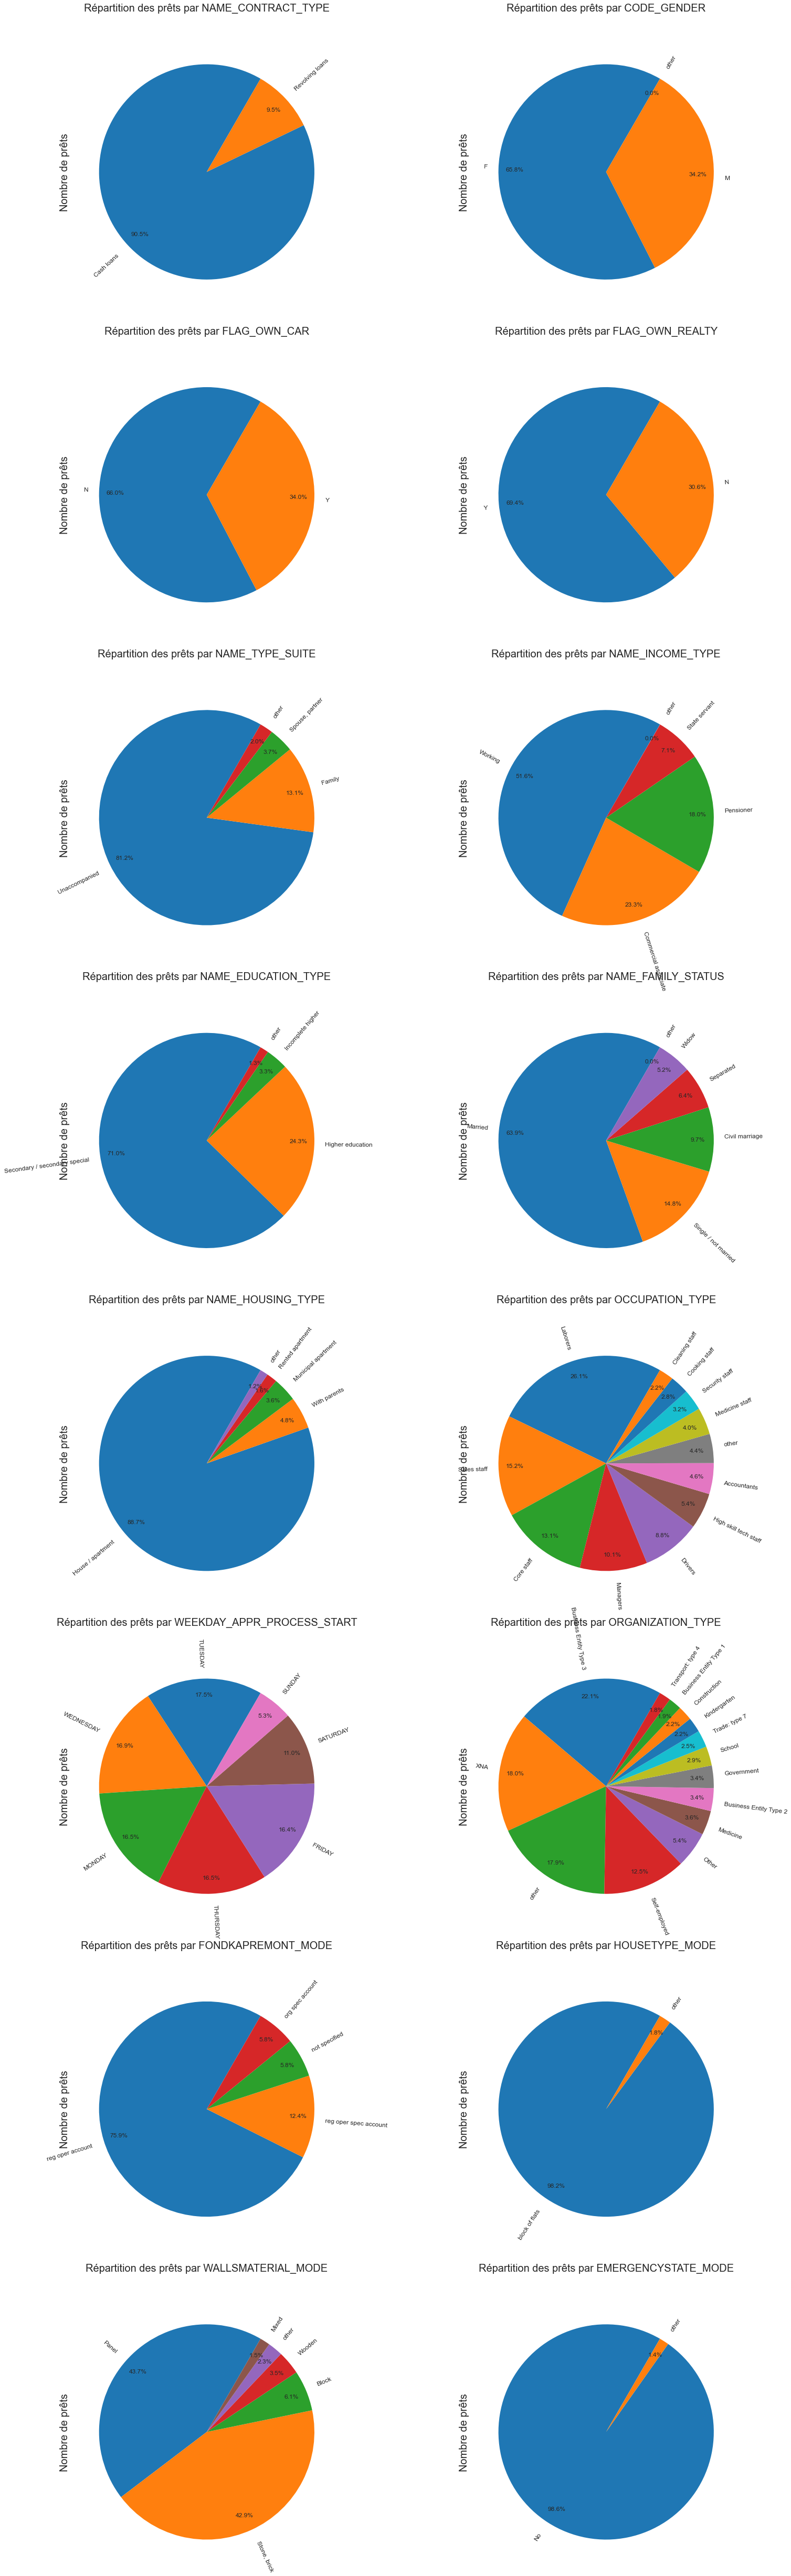

In [72]:
# Variables qualitatives
dth.drawPieplot(data, data.select_dtypes("object").columns, (25,100))

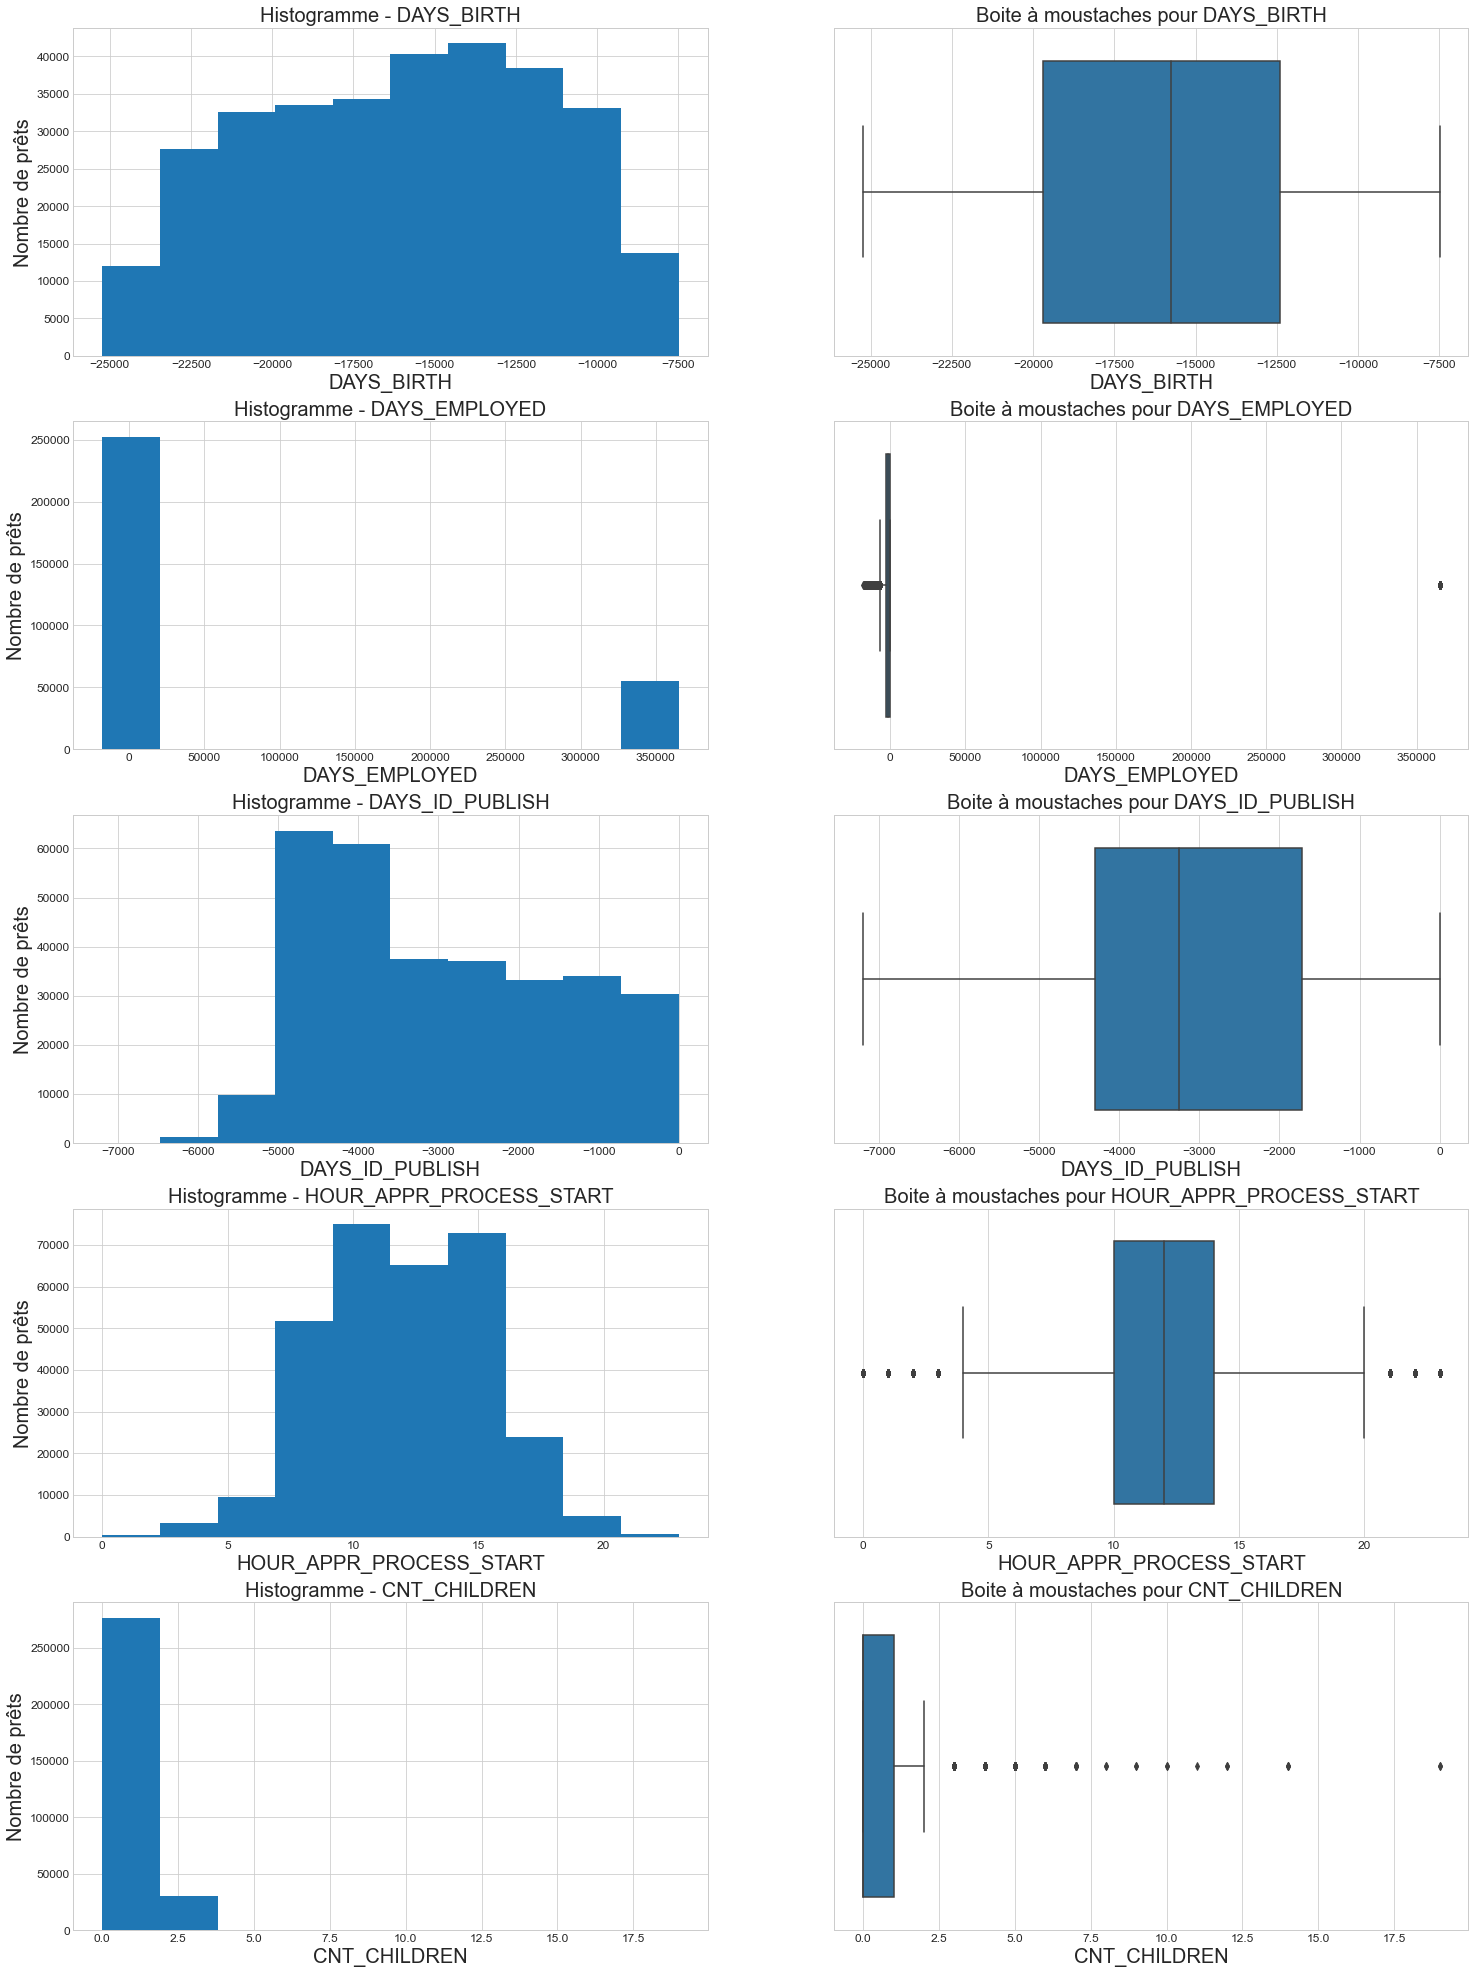

In [73]:
# Variables quantitatives (entiers)
dth.drawHistAndBoxPlot(data, ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START', 'CNT_CHILDREN'], (25,35))

Je n'ai gardé que les colonnes les plus pertinentes à analyser avec ces graphes, les autres étant des valeurs boolean, les résultats ne sont pas interprétables graphiquement

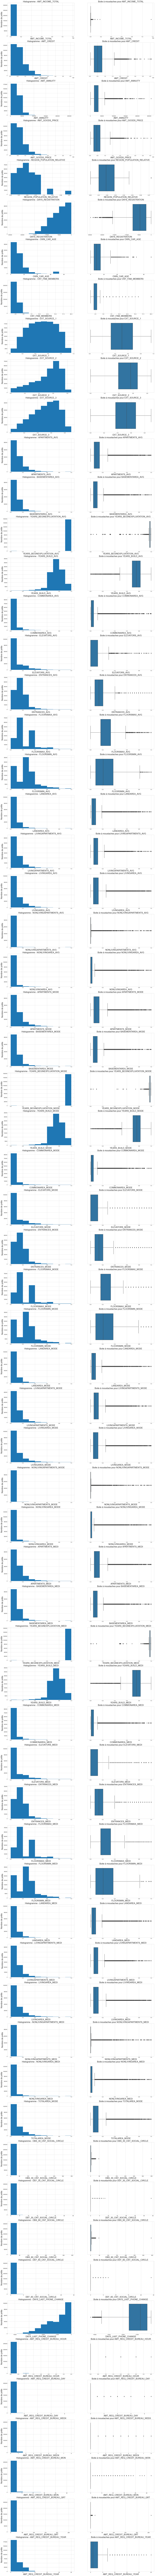

In [74]:
# Variables quantitatives (nombres flottants)
dth.drawHistAndBoxPlot(data, data.select_dtypes("float64").columns, (25,450))

Ces diagrammes en camembert, histogrammes et boîtes à moustache permettent d'observer la répartition des valeurs et les éventuelles valeurs aberrantes (on abordera ce point dans la partie nettoyage du jeu de données)

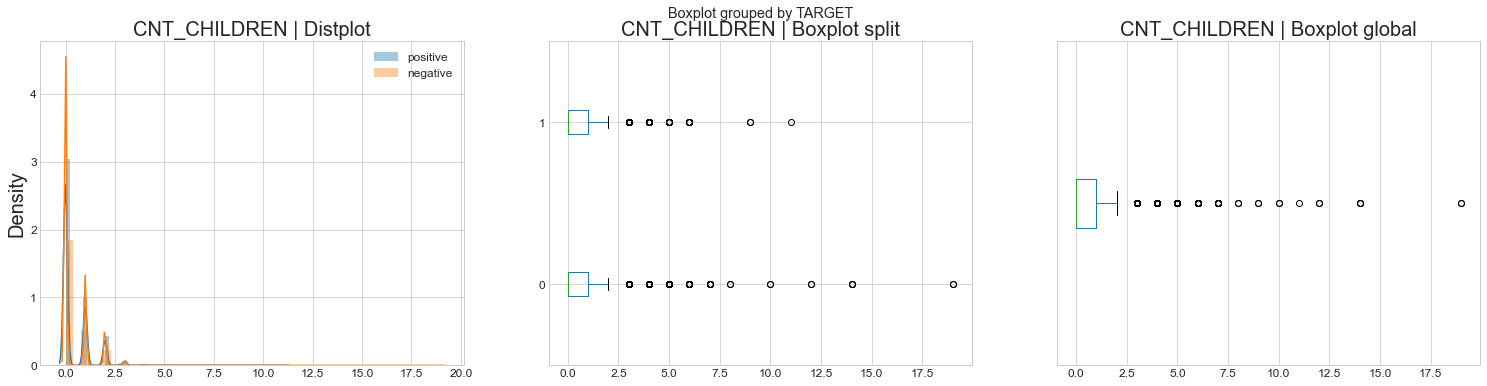

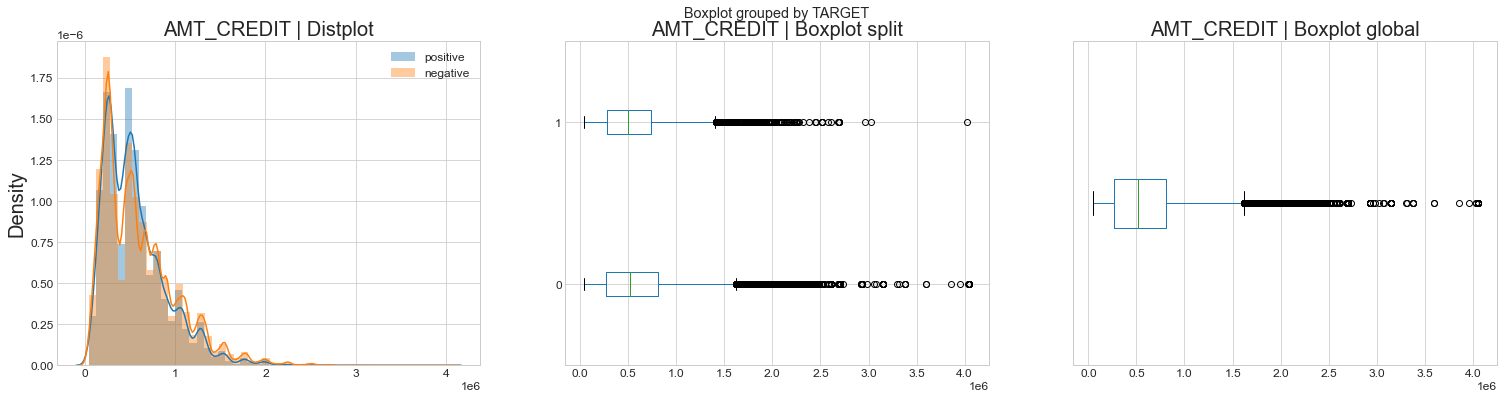

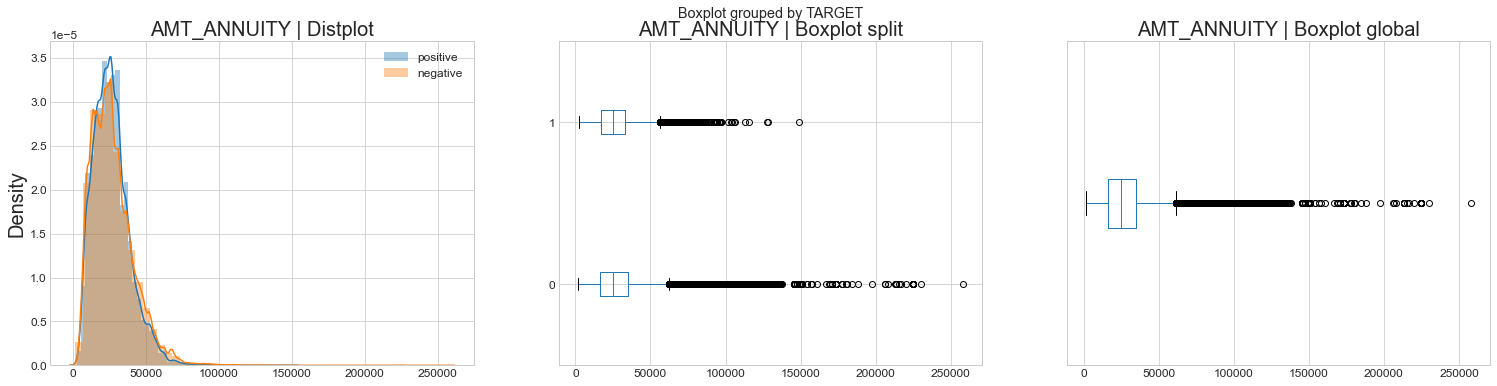

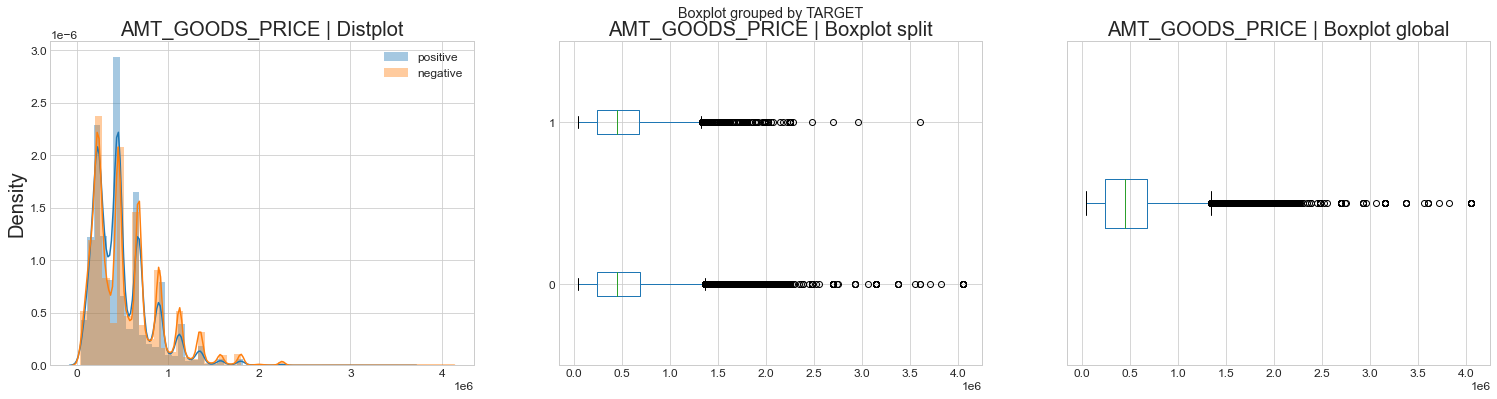

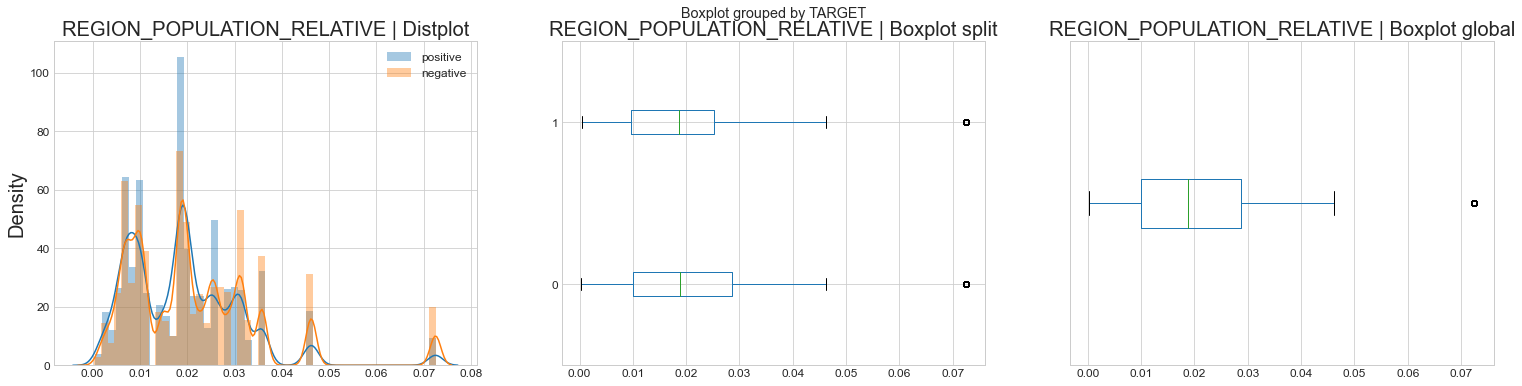

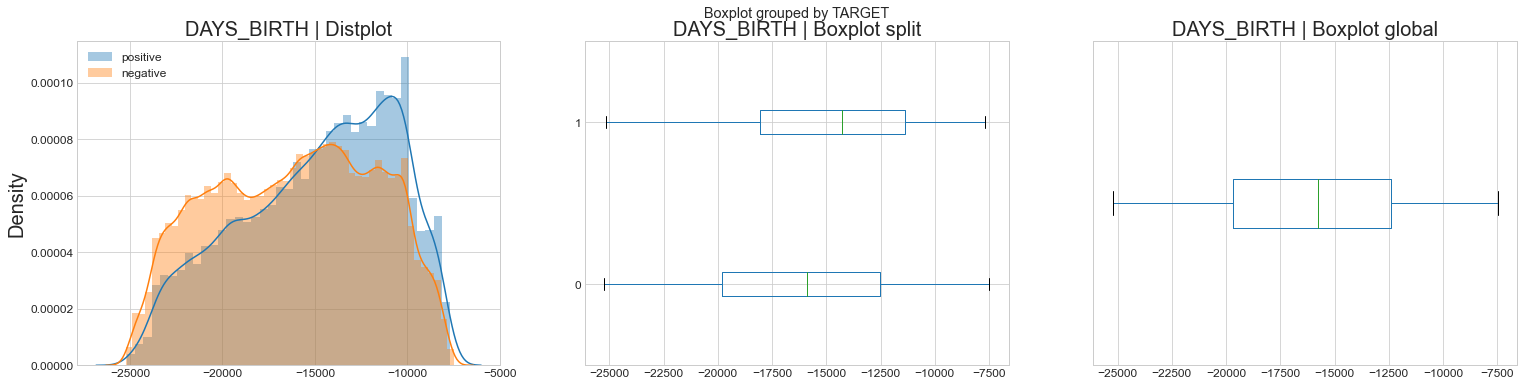

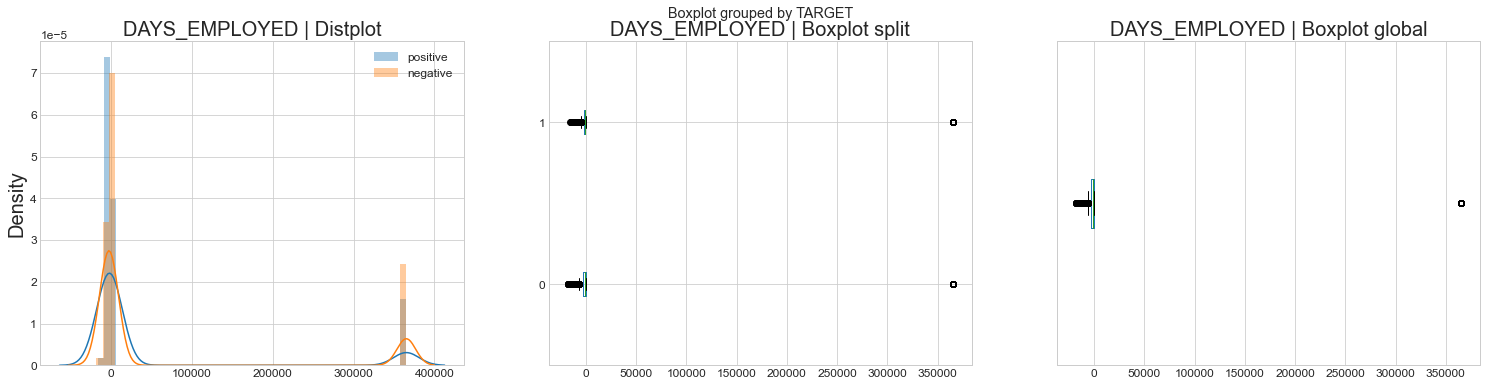

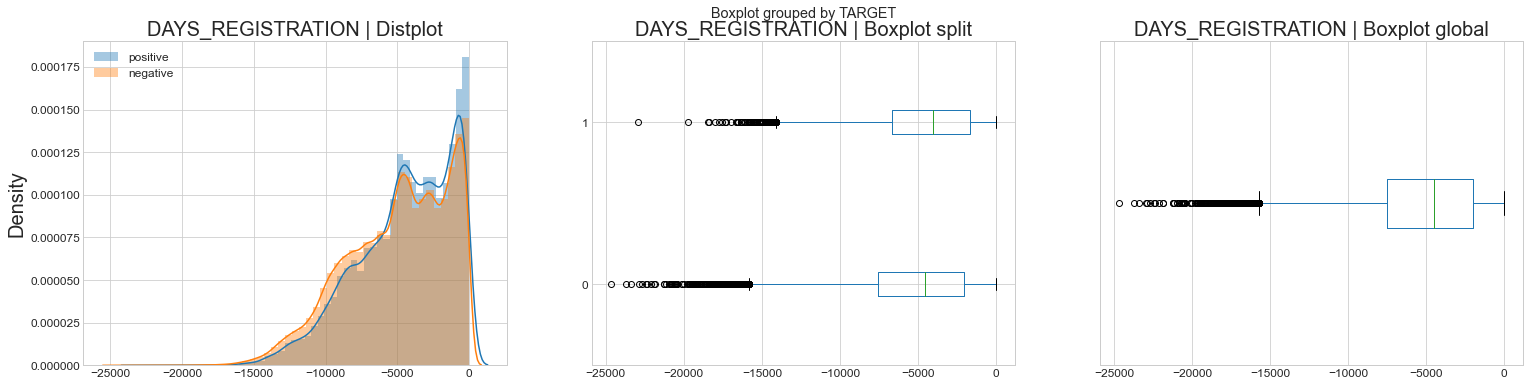

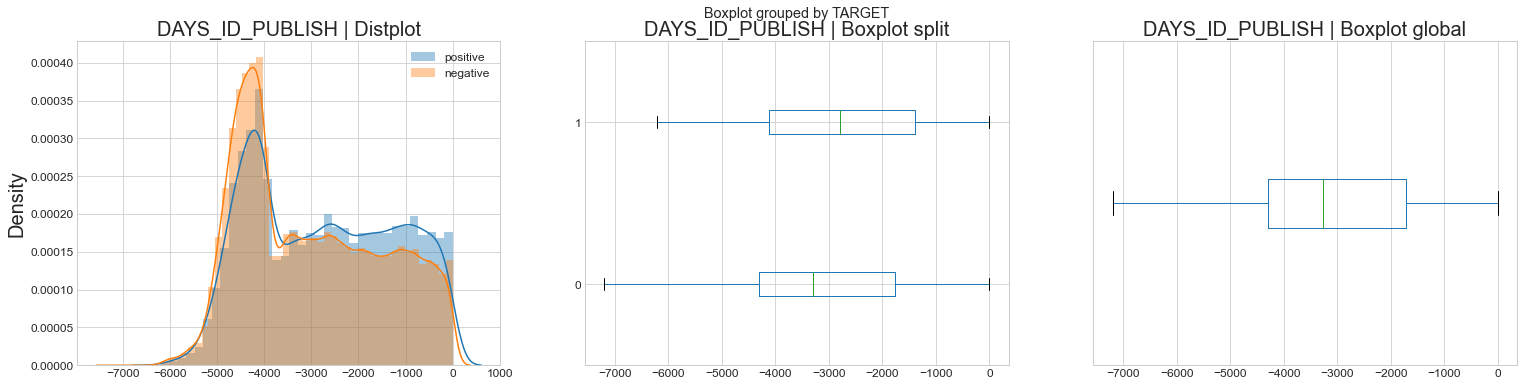

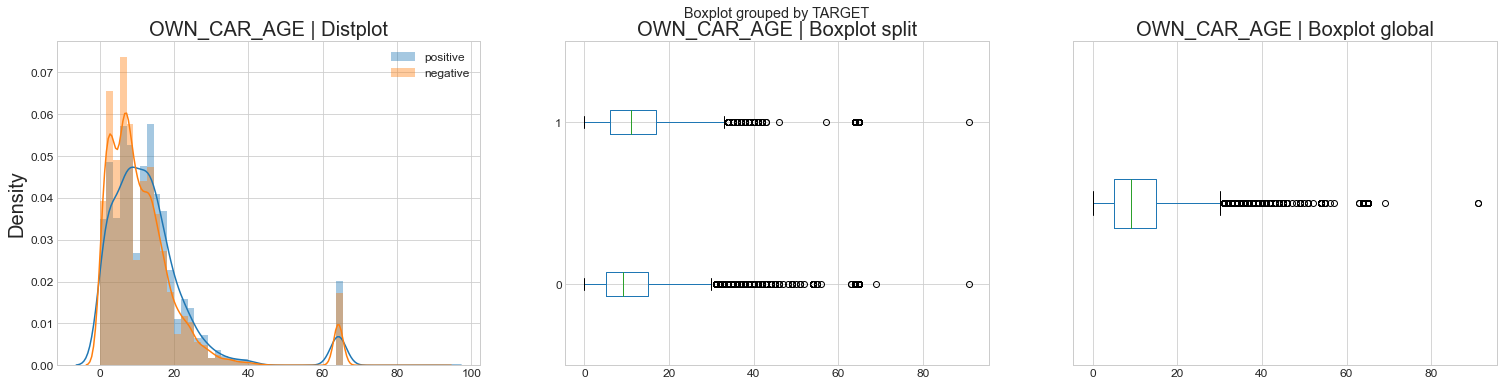

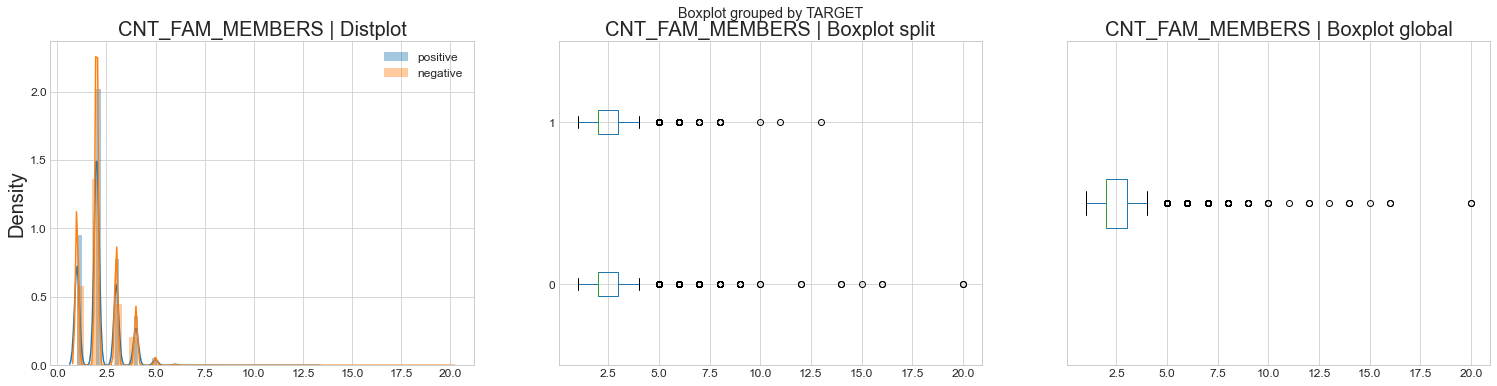

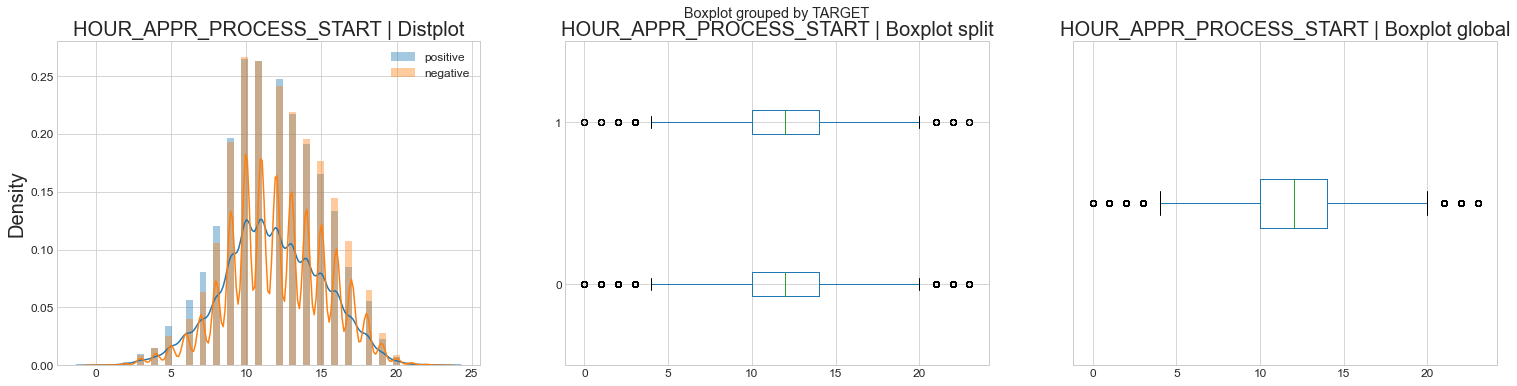

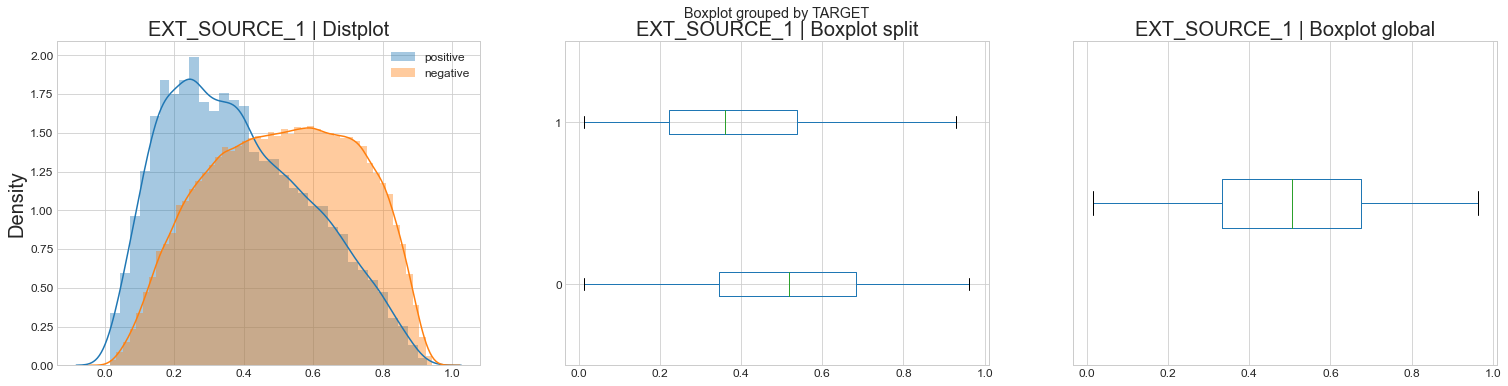

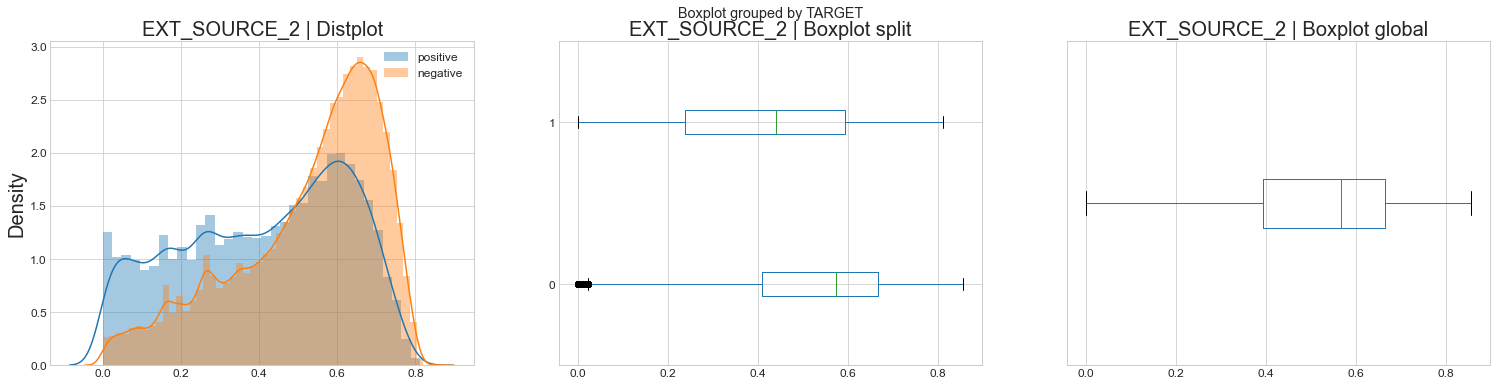

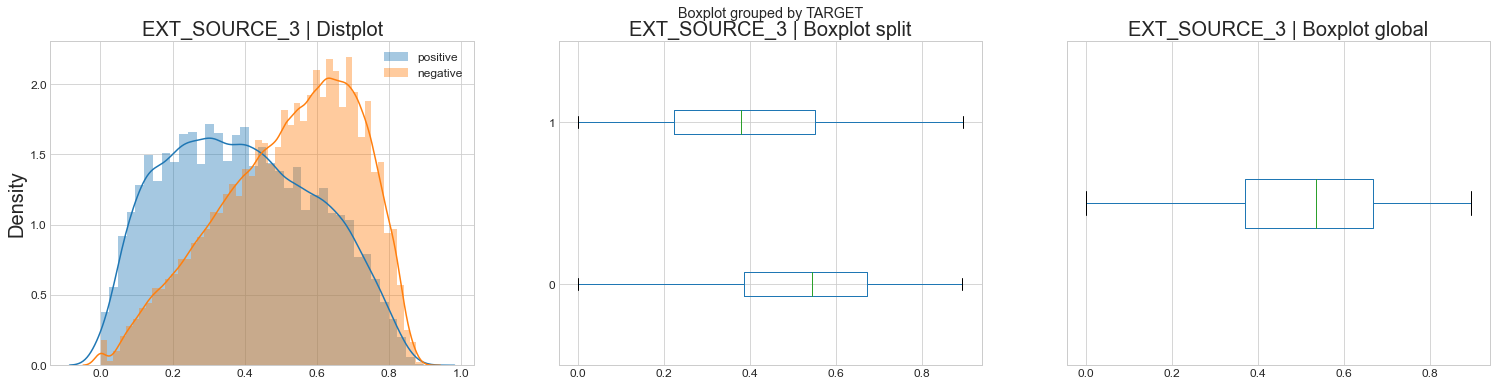

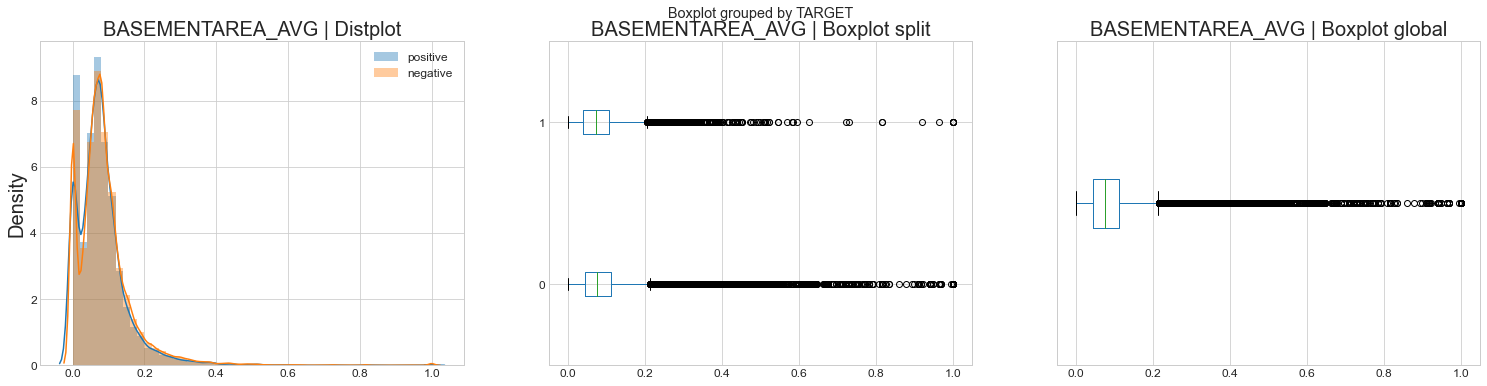

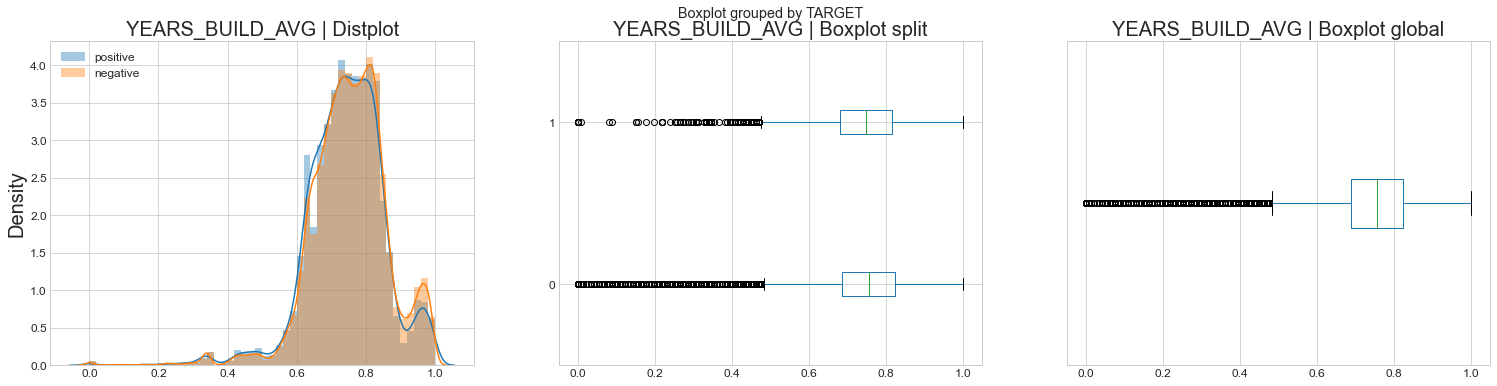

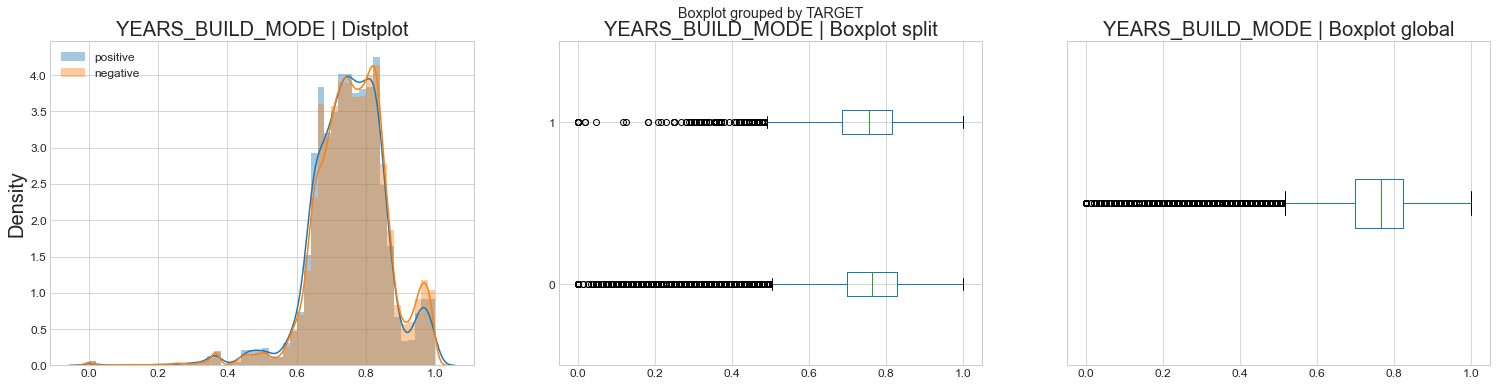

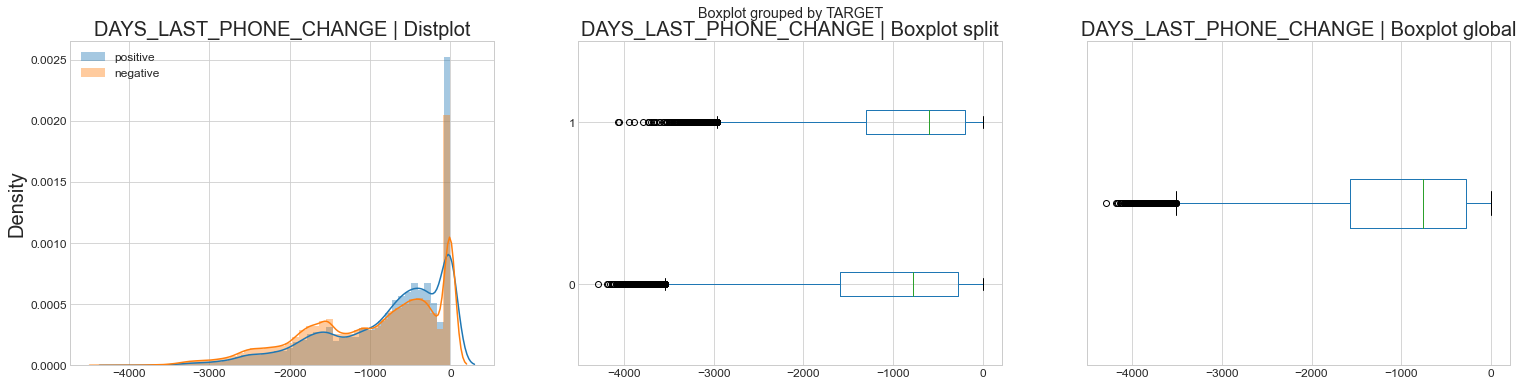

In [75]:
columns_analyse = ['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APPARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'DAYS_LAST_PHONE_CHANGE']
positive_target = data[data["TARGET"]==1]
negative_target = data[data['TARGET']==0]
dth.analyse_num_with_target_bin(positive_target, negative_target, 'TARGET', columns_analyse)

En ne gardant seulement les variables les plus pertinentes pour observer la disparité entre la classe 0 et 1 de la TARGET, on peut déjà voir une corrélation assez marquée sur certaines variables comme:
- DAYS_BIRTH
- DAYS_ID_PUBLISH
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3

# Merge des fichiers, nettoyage et création de nouvelles variables

On va merger ensemble les fichiers **application_train.csv** et **application_test.csv**, pour y effectuer un nettoyage, un encodage des variables, et la création de nouvelles variables, afin de rendre le tout homogène.

Par la suite on redivisera le data en un data_train et un data_test comme à l'origine.

In [76]:
data = data.append(test_data).reset_index()

In [77]:
dth.displayDataShape("data", data)

data : 356255 lignes et 123 colonnes



### Nettoyage
On va ici supprimer les valeurs aberrantes pour les variables **CODE_GENDER** et **DAYS_EMPLOYED**

Pour les autres variables, les valeurs aberrantes des boîtes à moustache analysées précedemment, correspondent à des features dont les informations en notre possession ne permettent pas de conclure sur la pertinence de ces valeurs.

In [78]:
data['CODE_GENDER'].value_counts()

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

On supprime les 4 lignes qui ne contiennent pas de valeurs adéquates pour la variable 'CODE_GENDER'

In [79]:
data = data[data['CODE_GENDER'] != "XNA"]

In [80]:
data['DAYS_EMPLOYED'].describe()

count    356251.000000
mean      64317.999498
std      141706.142236
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:ylabel='Frequency'>

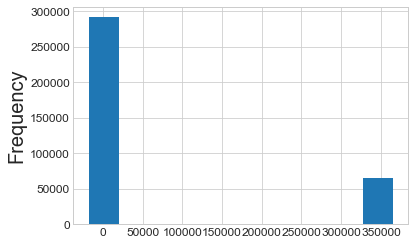

In [81]:
data['DAYS_EMPLOYED'].plot.hist()

Il ne doit y avoir que des valeurs négatives pour la variable 'DAYS_EMPLOYED', on remplace donc les valeurs aberrantes par la valeur NaN

In [82]:
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

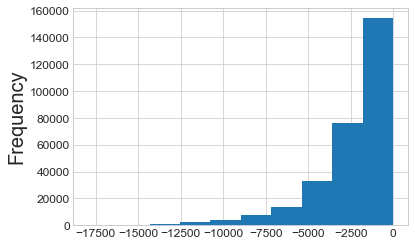

In [83]:
data['DAYS_EMPLOYED'].plot.hist();

### Encodage des variables catégorielles
Ici on va encoder les variables qualitatives afin de transformer les données en valeurs numériques, car les modèles que l'on va entraîner ne peuvent pas travailler sur des données qualitatives.

Pour les variables n'ayant que 2 valeurs possibles, on va simplement changer les valeurs en valeurs numériques.

Par contre pour les variables qui ont plus de 2 valeurs possibles, on va utiliser le one hot encoding, parce qu'on ne veut pas créer d'ordre entre les valeurs comme 0 < 1 < 2 ....

Le one hot encoding va diviser la colonne en plusieurs autres colonnes (une colonne pour chaque valeur possible), et indiquer 1 pou 0 dans les valeurs, en fonction de quelle colonne a quelle valeur. 

In [84]:
data_object_infos = data.select_dtypes("object").describe().T
data_object_infos["unique"] = data.select_dtypes("object").apply( pd.Series.unique, axis=0)
data_object_infos["nunique"] = data.select_dtypes("object").apply( pd.Series.nunique, axis=0)
data_object_infos

count  \
NAME_CONTRACT_TYPE          356251   
CODE_GENDER                 356251   
FLAG_OWN_CAR                356251   
FLAG_OWN_REALTY             356251   
NAME_TYPE_SUITE             354048   
NAME_INCOME_TYPE            356251   
NAME_EDUCATION_TYPE         356251   
NAME_FAMILY_STATUS          356251   
NAME_HOUSING_TYPE           356251   
OCCUPATION_TYPE             244257   
WEEKDAY_APPR_PROCESS_START  356251   
ORGANIZATION_TYPE           356251   
FONDKAPREMONT_MODE          113161   
HOUSETYPE_MODE              178336   
WALLSMATERIAL_MODE          176018   
EMERGENCYSTATE_MODE         188288   

                                                                       unique  \
NAME_CONTRACT_TYPE                              [Cash loans, Revolving loans]   
CODE_GENDER                                                            [M, F]   
FLAG_OWN_CAR                                                           [N, Y]   
FLAG_OWN_REALTY                                                        [Y, N]   
NAME_TYPE_SUITE             [Unaccompanied, Family, Spouse, partner, Child...   
NAME_INCOME_TYPE            [Working, State servant, Commercial associate,...   
NAME_EDUCATION_TYPE         [Secondary / secondary special, Higher educati...   
NAME_FAMILY_STATUS          [Single / not married, Married, Civil marriage...   
NAME_HOUSING_TYPE           [House / apartment, Rented apartment, With par...   
OCCUPATION_TYPE             [Laborers, Core staff, Accountants, Managers, ...   
WEEKDAY_APPR_PROCESS_START  [WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY...   
ORGANIZATION_TYPE           [Business Entity Type 3, School, Government, R...   
FONDKAPREMONT_MODE          [reg oper account, nan, org spec account, reg ...   
HOUSETYPE_MODE              [block of flats, nan, terraced house, specific...   
WALLSMATERIAL_MODE          [Stone, brick, Block, nan, Panel, Mixed, Woode...   
EMERGENCYSTATE_MODE                                            [No, nan, Yes]   

                                                      top    freq  nunique  
NAME_CONTRACT_TYPE                             Cash loans  326537        2  
CODE_GENDER                                             F  235126        2  
FLAG_OWN_CAR                                            N  235233        2  
FLAG_OWN_REALTY                                         Y  246966        2  
NAME_TYPE_SUITE                             Unaccompanied  288250        7  
NAME_INCOME_TYPE                                  Working  183304        8  
NAME_EDUCATION_TYPE         Secondary / secondary special  252377        5  
NAME_FAMILY_STATUS                                Married  228712        6  
NAME_HOUSING_TYPE                       House / apartment  316510        6  
OCCUPATION_TYPE                                  Laborers   63841       18  
WEEKDAY_APPR_PROCESS_START                        TUESDAY   63651        7  
ORGANIZATION_TYPE                  Business Entity Type 3   78832       58  
FONDKAPREMONT_MODE                       reg oper account   85953        4  
HOUSETYPE_MODE                             block of flats  175159        3  
WALLSMATERIAL_MODE                                  Panel   77308        7  
EMERGENCYSTATE_MODE                                    No  185604        2

In [85]:
# Object label encoder
le = LabelEncoder()
le_count = 0
col_encoded = []

for col in data:
    if data[col].dtype == 'object':
        if len(list(data[col].unique())) <= 2:
            le.fit(data[col])
            data[col] = le.transform(data[col])
            le_count += 1
            col_encoded.append(col)

print(f"{le_count} colonnes ont été encodées :")
for col in col_encoded:
    print(f"- {col}")

4 colonnes ont été encodées :
- NAME_CONTRACT_TYPE
- CODE_GENDER
- FLAG_OWN_CAR
- FLAG_OWN_REALTY


In [86]:
data, cols_one_hot_encoded = dth.one_hot_encoder(data, False)
print(f'{len(cols_one_hot_encoded)} colonnes on été "one hot encoded" :')
for col in cols_one_hot_encoded:
    print(f"- {col}")

131 colonnes on été "one hot encoded" :
- NAME_TYPE_SUITE_Children
- NAME_TYPE_SUITE_Family
- NAME_TYPE_SUITE_Group of people
- NAME_TYPE_SUITE_Other_A
- NAME_TYPE_SUITE_Other_B
- NAME_TYPE_SUITE_Spouse, partner
- NAME_TYPE_SUITE_Unaccompanied
- NAME_INCOME_TYPE_Businessman
- NAME_INCOME_TYPE_Commercial associate
- NAME_INCOME_TYPE_Maternity leave
- NAME_INCOME_TYPE_Pensioner
- NAME_INCOME_TYPE_State servant
- NAME_INCOME_TYPE_Student
- NAME_INCOME_TYPE_Unemployed
- NAME_INCOME_TYPE_Working
- NAME_EDUCATION_TYPE_Academic degree
- NAME_EDUCATION_TYPE_Higher education
- NAME_EDUCATION_TYPE_Incomplete higher
- NAME_EDUCATION_TYPE_Lower secondary
- NAME_EDUCATION_TYPE_Secondary / secondary special
- NAME_FAMILY_STATUS_Civil marriage
- NAME_FAMILY_STATUS_Married
- NAME_FAMILY_STATUS_Separated
- NAME_FAMILY_STATUS_Single / not married
- NAME_FAMILY_STATUS_Unknown
- NAME_FAMILY_STATUS_Widow
- NAME_HOUSING_TYPE_Co-op apartment
- NAME_HOUSING_TYPE_House / apartment
- NAME_HOUSING_TYPE_Municipal

In [87]:
dth.displayDataShape("Data après l'encodage", data)

Data après l'encodage : 356251 lignes et 242 colonnes



### Création de nouvelles features

In [88]:
data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
del test_data
gc.collect()

49301

De manière à rendre notre jeu de données plus interprétable, on va créer de nouvelles features à partir des features actuelles.

Les nouvelles features sont :
- **DAYS_EMPLOYED_PERC** (% de jours employés par rapport à l'âge de la personne)
- **INCOME_CREDIT_PERC** (% entre le revenu et le montant du crédit)
- **INCOME_PER_PERSON** (Revenu divisé par le nombre de membres dans la famille)
- **ANNUITY_INCOME_PERC** (% entre le crédit de rente et le revenu)
- **PAYMENT_RATE** (% entre le crédit de  rente et le montant du crédit)

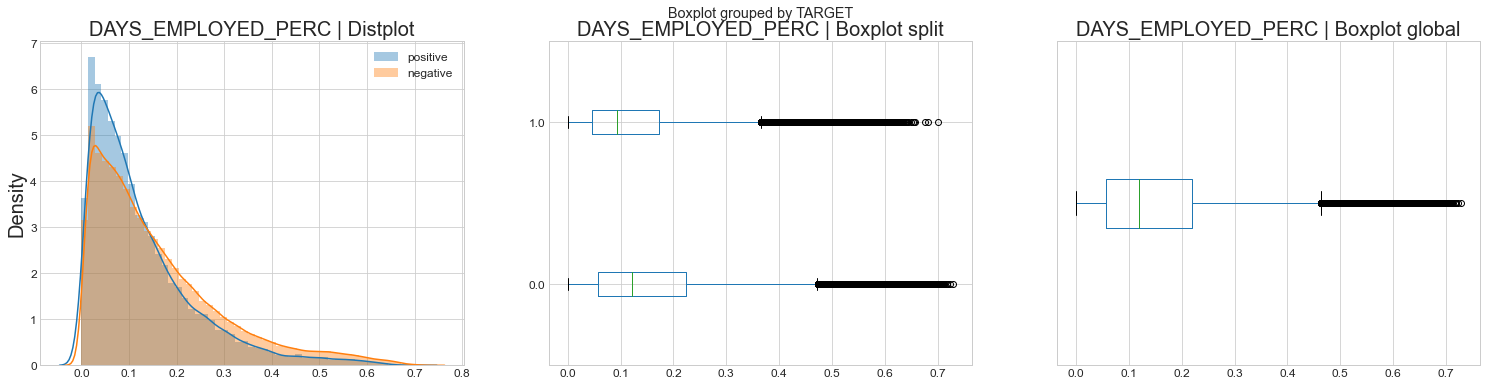

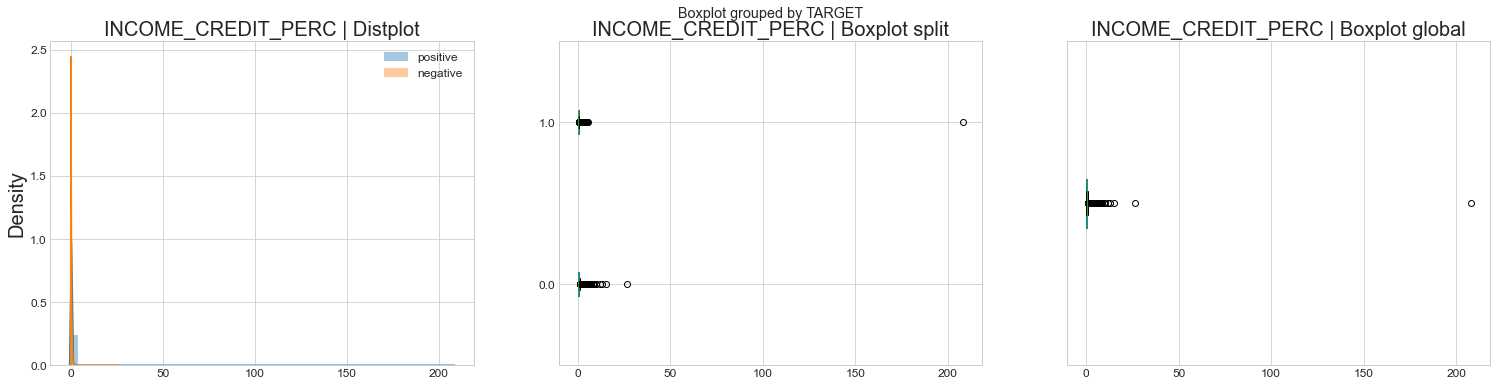

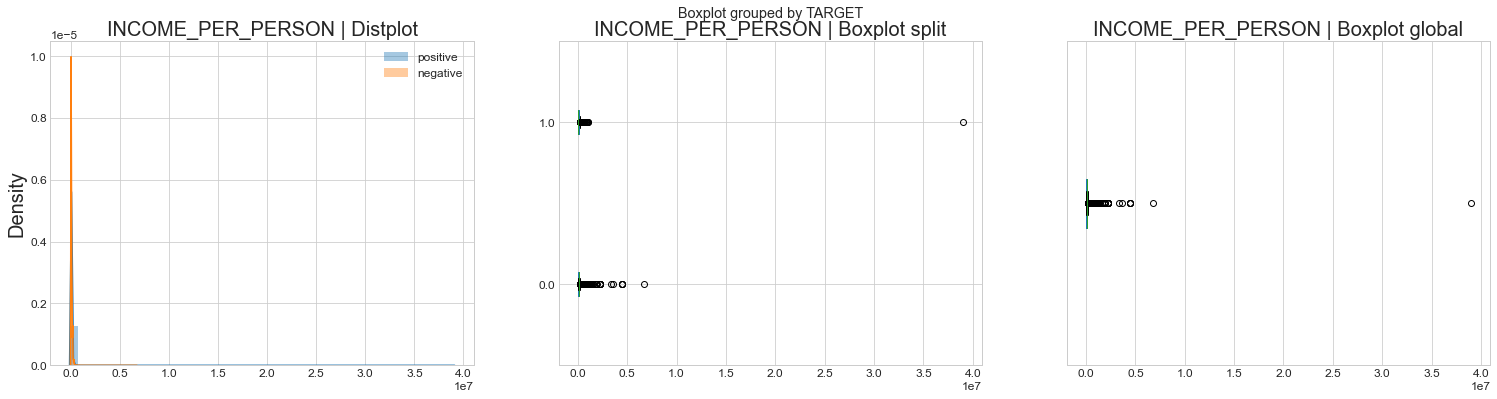

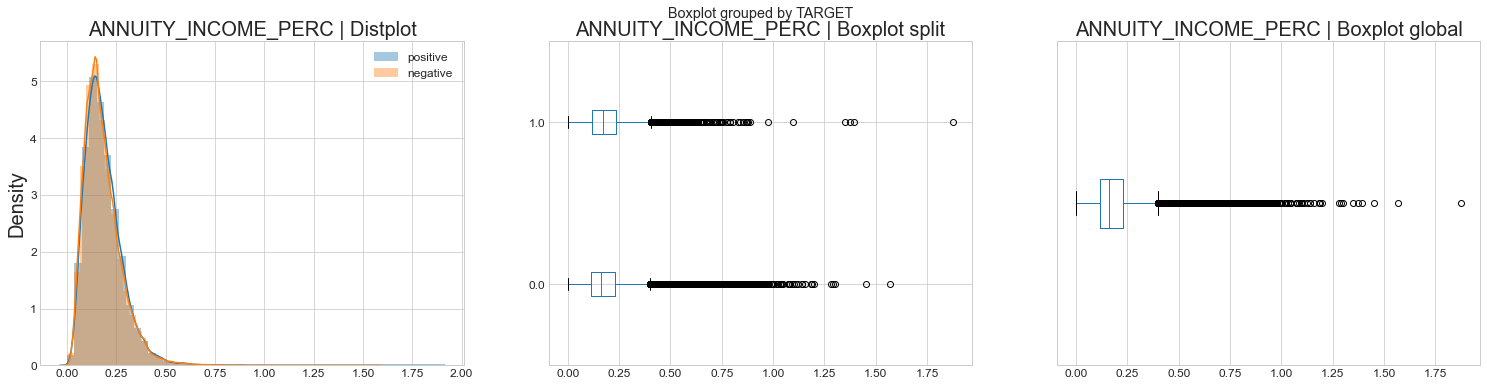

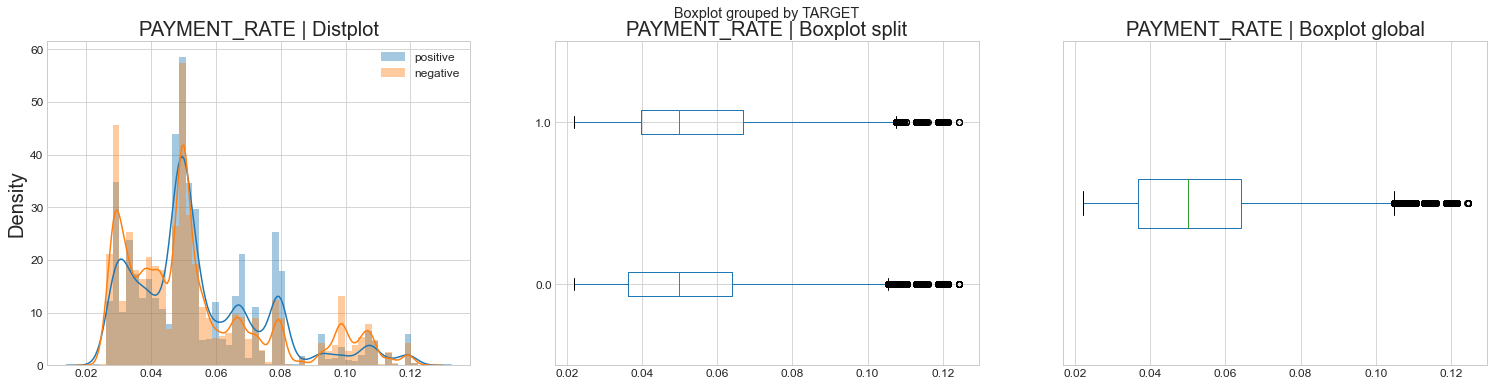

In [89]:
columns_analyse = ['DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE']
positive_target = data[data["TARGET"]==1]
negative_target = data[data['TARGET']==0]
dth.analyse_num_with_target_bin(positive_target, negative_target, 'TARGET', columns_analyse)

# Fusion des autres fichiers, encodage et créations d'autres variables
On reprend le même principe pour les autres fichiers et on les ajoute à notre fichier de data. La jonction se fait grâce au **SK_ID_CURR**

Pour se faire, on récupère des méthodes du script du fichier **lightGBM_script.ipynb**, qui est un script provenant d'un kernel Kaggle, et permettant d'aller plus vite sur la préparation des données

Fichiers **Bureau et bureau_balance**

In [90]:
bureau = pd.read_csv('data/bureau.csv')
bb = pd.read_csv('data/bureau_balance.csv')

bureau = dth.bureau_and_balance(bureau, bb)

dth.displayDataShape("Bureau data", bureau)
data = data.join(bureau, how='left', on='SK_ID_CURR')
del bureau

Bureau data : 305811 lignes et 116 colonnes



Fichier **previous_application**

In [91]:
prev = pd.read_csv('data/previous_application.csv')

prev = dth.previous_applications(prev)

dth.displayDataShape("Previous application data", prev)
data = data.join(prev, how='left', on='SK_ID_CURR')
del prev

Previous application data : 338857 lignes et 249 colonnes



Fichier **POS-CASH balance**

In [92]:
pos = pd.read_csv('data/POS_CASH_balance.csv')

pos = dth.pos_cash(pos)

dth.displayDataShape("POS-CASH balance data", pos)
data = data.join(pos, how='left', on='SK_ID_CURR')
del pos

POS-CASH balance data : 337252 lignes et 18 colonnes



Fichier **installments payments**

In [93]:
ins = pd.read_csv('data/installments_payments.csv')

ins = dth.installments_payments(ins)

dth.displayDataShape("Installments payments data", ins)
data = data.join(ins, how='left', on='SK_ID_CURR')
del ins

Installments payments data : 339587 lignes et 26 colonnes



Fichier **credit card balance**

In [94]:
cc = pd.read_csv('data/credit_card_balance.csv')

cc = dth.credit_card_balance(cc)

dth.displayDataShape("Credit card balance data", cc)
data = data.join(cc, how='left', on='SK_ID_CURR')
del cc

Credit card balance data : 103558 lignes et 141 colonnes



On sauvegarde le data final dans le fichier **merge.csv**, qui nou servira ensuite dans le notebook pour l'entraînement des modèles de Machine Learning

In [103]:
data.to_csv('merge.csv', index=False)